In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import power_transform 
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier   



# Data exploration

In [2]:
#load dataset
df = pd.read_csv("spotify_decades")

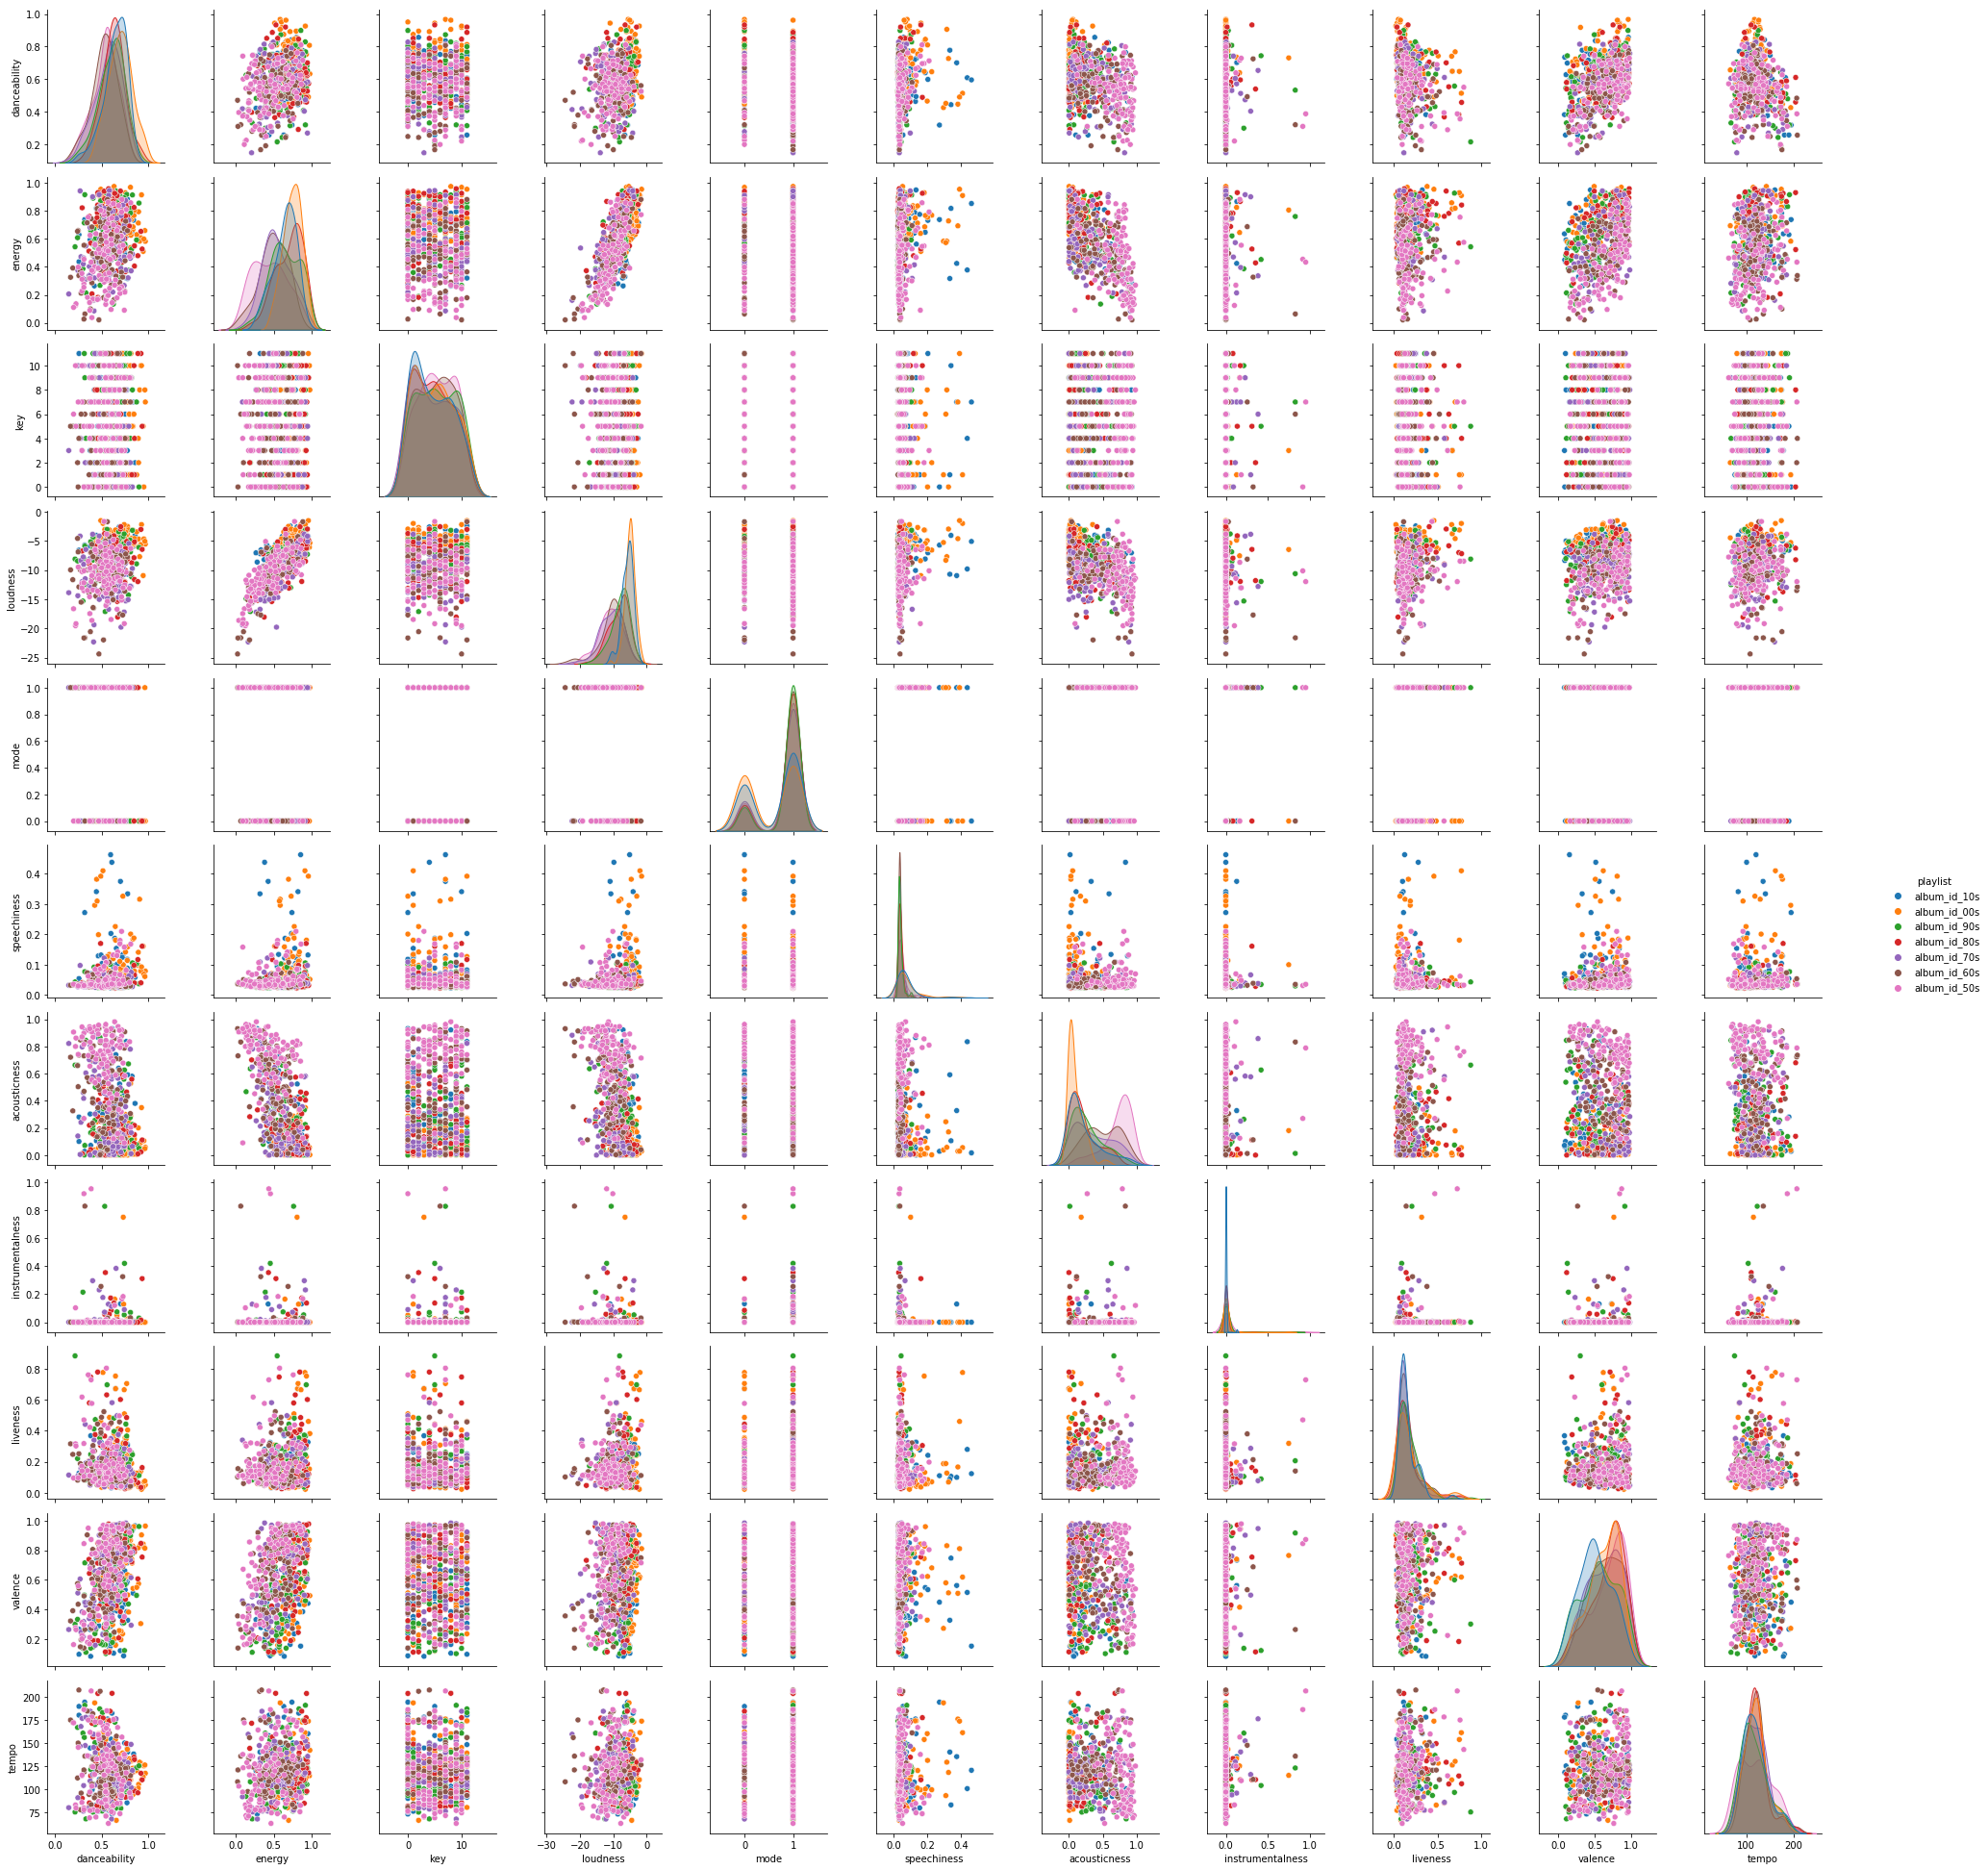

In [3]:
#view pairplot
#energy with loudness and energy with acousticness looks correlated
sns.pairplot(df, hue='playlist')

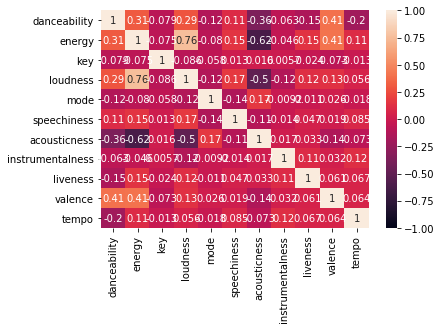

In [4]:
#plot correlation between features
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.rcParams['figure.figsize']=(10,10)

In [5]:
#searching for features with low variance
#speechiness,instrumentalness has low std
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000
mean,0.599608,0.599511,4.926761,-8.508424,0.761972,0.053905,0.338156,0.014410,0.168990,0.615315,118.886169
std,0.143711,0.206985,3.536270,3.683115,0.426177,0.052149,0.294960,0.082157,0.135133,0.236646,27.147039
min,0.149000,0.021000,0.000000,-24.385000,0.000000,0.022800,0.000065,0.000000,0.023400,0.082700,62.658000
25%,0.514500,0.467000,2.000000,-10.726000,1.000000,0.031200,0.075200,0.000000,0.086825,0.446000,98.285750
50%,0.610000,0.620000,5.000000,-7.768000,1.000000,0.036800,0.249000,0.000002,0.119000,0.629000,117.483000
75%,0.702000,0.762750,8.000000,-5.732750,1.000000,0.052675,0.592000,0.000171,0.202000,0.811750,132.592250
max,0.967000,0.976000,11.000000,-1.538000,1.000000,0.463000,0.982000,0.954000,0.882000,0.985000,207.356000


In [6]:
#keep only columns that contains features
X = df.drop(["playlist", "track_id", "track_name", "artist"], axis=1) 
#define target variable
y=df['playlist']
#scale features
scaler = StandardScaler().fit(X)
scaled_X = scaler.transform(X)
#split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, random_state=42, stratify=y)

C:\Users\urban\AppData\Roaming\Python\Python36\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


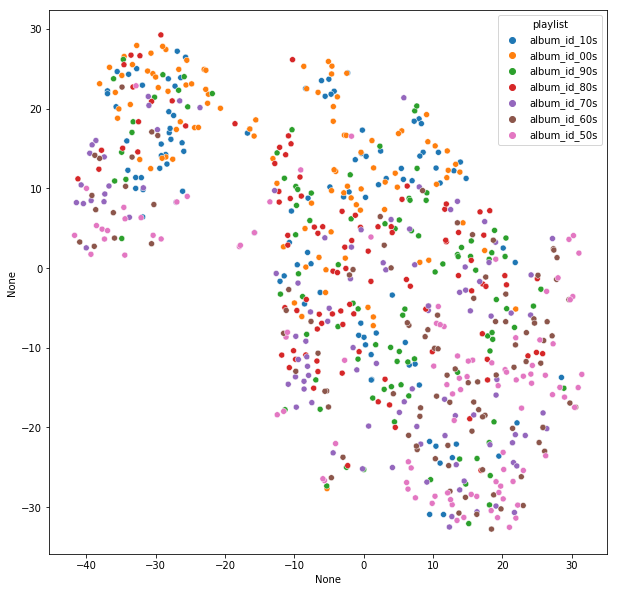

In [7]:
#Visualize data using TSNE
m=TSNE(learning_rate=100)
tsne_features=m.fit_transform(scaled_X)
x_t=tsne_features[:,0]
y_t=tsne_features[:,1]
y_t.shape
sns.scatterplot(x_t, y_t, hue='playlist', data=df)

# Feature selection

In [8]:
#how each feature contributes to the accuracy of model using Random Forest Classifier
#initiate an fit the random forest model to the training data
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

#calculate the accuracy
acc = accuracy_score(y_test, rf.predict(X_test))

#print the importance for each  feature
print(dict(zip(X.columns, rf.feature_importances_.round(2))))

#print overall accuracy
print("{0:.1%} accuracy on test set.".format(acc))

{'danceability': 0.09, 'energy': 0.1, 'key': 0.05, 'loudness': 0.15, 'mode': 0.01, 'speechiness': 0.1, 'acousticness': 0.15, 'instrumentalness': 0.07, 'liveness': 0.08, 'valence': 0.11, 'tempo': 0.08}
42.7% accuracy on test set.


It look like energy, loudness, speechiness, acousticness and valence has the highest explanatory power.


In [9]:
#finding best eatures using ensamble models with RFE 
masks = []
estimators = [LogisticRegression(),RandomForestClassifier(), GradientBoostingClassifier()]
for e in estimators:
    
    rfe = RFE(estimator=e, 
                 n_features_to_select=8, verbose=1) #selecting best 8 features by each of 3 selected estimators
    rfe.fit(X_train, y_train)

#calculate accuracy on the test set
    acc = accuracy_score(y_test, rfe.predict(X_test))
    
    print('The model can explain {0:.1%} of the variance in the test set'.format(acc))
    print(rfe.support_)
#assign the support array to gb_mask
    masks.append(rfe.support_)

Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
The model can explain 40.4% of the variance in the test set
[ True  True False  True  True  True  True  True False  True False]
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
The model can explain 43.8% of the variance in the test set
[ True  True False  True False  True  True False  True  True  True]
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
The model can explain 43.3% of the variance in the test set
[ True  True False  True False  True  True False  True  True  True]


In [10]:
# Sum the votes of the three models
votes = np.sum(masks, axis=0)
print(votes)
# Create a mask for features selected by all 3 models
meta_mask = votes >= 3


[3 3 0 3 1 3 3 1 2 3 2]


In [11]:
#I will use only features chosen by all 3 models -> 6 features:
# danceability, energy, loudness, speechiness, acousticness ans valence
X_reduced = X.loc[:,meta_mask]
scaler = StandardScaler().fit(X_reduced)
standardized_X = scaler.transform(X_reduced)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, random_state=42, stratify=y)
print(X_reduced.columns)

Index(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'valence'],
      dtype='object')


# Model

Random Forest

In [12]:
#grid search Random Forest Classifier

parameters = {
    'min_samples_split': [6, 8, 10],
    "min_samples_leaf": [2, 3, 4, 5],
    "max_depth":[3,5, 7],
    "max_features":[0.6, 0.7, 0.8, 0.9],
    "n_estimators":[10,20,30,40]
    }
#passing the scoring function in the GridSearchCV
rf= GridSearchCV(RandomForestClassifier(), parameters, cv=3)
#fit it to the data
rf.fit(X,y)

#print the tuned parameters and score
print("Tuned Parameters: {}".format(rf.best_params_)) 
print("Best score is {}".format(rf.best_score_))


Tuned Parameters: {'max_depth': 5, 'max_features': 0.9, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 30}
Best score is 0.4309697489809054


GradientBoost

In [13]:
#grid search Gradient Boost Classifier
parameters = {
    'min_samples_split': [6, 8, 10],
    "min_samples_leaf": [2, 3, 4, 5],
    "max_depth":[3,5, 7],
    "max_features":[0.6, 0.7, 0.8, 0.9],
    "subsample":[0.7, 0.75, 0.8, 0.9],
    "n_estimators":[10,20,30,40]
    }

#passing the scoring function in the GridSearchCV
gb = GridSearchCV(GradientBoostingClassifier(), parameters, cv=3)
#fit it to the data
gb.fit(X,y)


#print the tuned parameters and score
print("Tuned Parameters: {}".format(gb.best_params_)) 
print("Best score is {}".format(gb.best_score_))

Tuned Parameters: {'max_depth': 7, 'max_features': 0.6, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 30, 'subsample': 0.7}
Best score is 0.43947412334024644


Logistic Regression

In [14]:
#grid search Logistic Regression
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'max_iter': list(range(100,800,100)),
    'solver' : ['liblinear']
    }

#passing the scoring function in the GridSearchCV
lr = GridSearchCV(LogisticRegression(), parameters, cv=3)
lr.fit(X,y)

#print the tuned parameters and score
print("Tuned Parameters: {}".format(lr.best_params_)) 
print("Best score is {}".format(lr.best_score_))




Tuned Parameters: {'C': 10, 'max_iter': 300, 'penalty': 'l1', 'solver': 'liblinear'}
Best score is 0.39155879758754675


# Ensamble

In [15]:
#define the list classifiers
classifiers = [ (' Gradient Boosting', gb), ('Random Forest', rf), ('Logistic Regression', lr)]

In [16]:
#iterate over the pre-defined list of classifiers
for clf_name, clf in classifiers:    
 
    #fit clf to the training set
    clf.fit(X_train, y_train)    
   
    #predict y_pred
    y_pred = clf.predict(X_test)
    
    #calculate accuracy
    accuracy = accuracy_score(y_pred, y_test) 
   
    #evaluate clf's accuracy on the test set
    print('{:s} : {:.3f}'.format(clf_name, accuracy))

 Gradient Boosting : 0.461
Random Forest : 0.388
Logistic Regression : 0.438


In [17]:

#instantiate a VotingClassifier vc
vc = VotingClassifier(estimators=classifiers)     

#fit vc to the training set
vc.fit(X_train, y_train)   

#evaluate the test set predictions
y_pred = vc.predict(X_test)

#calculate accuracy score
accuracy = accuracy_score(y_pred, y_test)
print('Voting Classifier: {:.3f}'.format(accuracy))

Voting Classifier: 0.478


We obtained best accuracy with ensamble model using Logistic regression, Gradient Boost Classifier and Random Forest Classifier